<a href="https://colab.research.google.com/github/illusoryTwin/FoR/blob/main/FoR_assig2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forward kinematics
### Let's introduce forward kinematics functions - they will help us while solving inverse kinematics problem

### Forward kinematics (symbolic)

In [1]:
import numpy as np
import sympy as sp

def rotate_x_sym(theta):
    cos_theta = sp.cos(theta)
    sin_theta = sp.sin(theta)
    rot_matrix_x = sp.Matrix([[1, 0, 0, 0],
                              [0, cos_theta, -sin_theta, 0],
                              [0, sin_theta, cos_theta, 0],
                              [0, 0, 0, 1]])
    return rot_matrix_x

def rotate_y_sym(theta):
    cos_theta = sp.cos(theta)
    sin_theta = sp.sin(theta)
    rot_matrix_y = sp.Matrix([[cos_theta, 0, sin_theta, 0],
                              [0, 1, 0, 0],
                              [-sin_theta, 0, cos_theta, 0],
                              [0, 0, 0, 1]])
    return rot_matrix_y

def rotate_z_sym(theta):
    cos_theta = sp.cos(theta)
    sin_theta = sp.sin(theta)
    rot_matrix_z = sp.Matrix([[cos_theta, -sin_theta, 0, 0],
                              [sin_theta, cos_theta, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    return rot_matrix_z

def translate_x_sym(dx):
    translation_matrix_x = sp.Matrix([[1, 0, 0, dx],
                                      [0, 1, 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    return translation_matrix_x

def translate_y_sym(dy):
    translation_matrix_y = sp.Matrix([[1, 0, 0, 0],
                                      [0, 1, 0, dy],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    return translation_matrix_y

def translate_z_sym(dz):
    translation_matrix_z = sp.Matrix([[1, 0, 0, 0],
                                      [0, 1, 0, 0],
                                      [0, 0, 1, dz],
                                      [0, 0, 0, 1]])
    return translation_matrix_z


# Let's derive the theoretical solution for the inverse kinematics problem

### The vector above is a column vector of translation from the matrix of transformation for the wrist center. It defines the position of the end-effector.

Dividing the second element of the vector by the first, we can retrieve $q_1$.


$$\tan(q_1) = -\dfrac{x}{y}$$


In [2]:
theta1, theta2, theta3, l1, l2, l3, l4 = sp.symbols('theta1 theta2 theta3 l1 l2 l3 l4')

def forward_kinematics_for_wrist_center_sym():
    T_0 = np.identity(4)
    T_01 = rotate_z_sym(theta1) @ translate_z_sym(l1) @ rotate_z_sym(sp.pi/2) @ rotate_x_sym(sp.pi/2)
    T_12 = rotate_z_sym(theta2) @ translate_x_sym(l2)
    T_23 = rotate_z_sym(theta3) @ translate_x_sym(l3+l4) @ rotate_y_sym(sp.pi/2) @ rotate_z_sym(sp.pi/2)
    T_ee_center = T_0 @ T_01 @ T_12 @ T_23
    return T_ee_center

wrist_center_config_matrix_symb = forward_kinematics_for_wrist_center_sym()

# Substitute numerical values into symbolic expression
numerical_subs = {l1: 0.3, l2: 1, l3: 0.3, l4: 0.5}
wrist_center_config_matrix_symb = wrist_center_config_matrix_symb.subs(numerical_subs)

# Convert pi symbol to numpy pi value
wrist_center_config_symb = wrist_center_config_matrix_symb.subs(sp.pi, np.pi)[:3, 3]
wrist_center_config_symb

Matrix([
[ 0.8*sin(theta1)*sin(theta2)*sin(theta3) - 0.8*sin(theta1)*cos(theta2)*cos(theta3) - 1.0*sin(theta1)*cos(theta2)],
[-0.8*sin(theta2)*sin(theta3)*cos(theta1) + 0.8*cos(theta1)*cos(theta2)*cos(theta3) + 1.0*cos(theta1)*cos(theta2)],
[                               0.8*sin(theta2)*cos(theta3) + 1.0*sin(theta2) + 0.8*sin(theta3)*cos(theta2) + 0.3]])

# Calculate $R_{36}$ to find $q_4$, $q_5$, $q_6$

In [3]:
import sympy as sp
import numpy as np

# Define symbolic variables
theta1, theta2, theta3, theta4, theta5, theta6, l1, l2, l3, l4, l5, l6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6 l1 l2 l3 l4 l5 l6')

# Define symbolic rotation and translation matrices
def rotate_z(theta):
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                      [sp.sin(theta), sp.cos(theta), 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

def translate_z(d):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, d],
                      [0, 0, 0, 1]])

def rotate_x(theta):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, sp.cos(theta), -sp.sin(theta), 0],
                      [0, sp.sin(theta), sp.cos(theta), 0],
                      [0, 0, 0, 1]])

def translate_y(d):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, 1, 0, d],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

# Define the wrist configuration function
def wrist_config(theta1, theta2, theta3, theta4, theta5, theta6):
    T_0 = sp.eye(4)
    T_34 = rotate_z(theta4) * translate_z(l4) * rotate_x(-sp.pi/2) * rotate_z(-sp.pi)
    T_45 = rotate_z(theta5) * translate_y(l5) * rotate_x(-sp.pi/2)
    T_56 = rotate_z(theta6) * translate_z(l6)

    T = T_0 * T_34 * T_45 * T_56

    R = T[0:3, 0:3]  # Extract the 3x3 rotational matrix from the top-left corner
    return R

# Symbolically solve the wrist configuration
wrist_config_symb = wrist_config(theta1, theta2, theta3, theta4, theta5, theta6)

# Substitute numerical values for l1, l2, ..., l6
numerical_subs = {l1: 0.3, l2: 1, l3: 0.3, l4: 0.5, l5: 0.3, l6: 0.4}
wrist_config_numerical = wrist_config_symb.subs(numerical_subs)

# Evaluate the numerical result
wr_center = wrist_config_numerical.evalf()
wr_center

Matrix([
[ sin(theta4)*sin(theta6) - cos(theta4)*cos(theta5)*cos(theta6), sin(theta4)*cos(theta6) + sin(theta6)*cos(theta4)*cos(theta5), sin(theta5)*cos(theta4)],
[-sin(theta4)*cos(theta5)*cos(theta6) - sin(theta6)*cos(theta4), sin(theta4)*sin(theta6)*cos(theta5) - cos(theta4)*cos(theta6), sin(theta4)*sin(theta5)],
[                                       sin(theta5)*cos(theta6),                                      -sin(theta5)*sin(theta6),             cos(theta5)]])

# **SOLUTION for the inverse kinematics problem**
# Let's define forward kinematics functions



In [6]:
import numpy as np

# Define the robot's geometry
l1 = 0.3
l2 = 1
l3 = 0.3
l4 = 0.5
l5 = 0.3
l6 = 0.4

# l1 = 1
# l2 = 1
# l3 = 1
# l4 = 1
# l5 = 1
# l6 = 1

# Define rotation and translation functions
def rotate_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0, 0],
                     [np.sin(theta), np.cos(theta), 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def rotate_x(theta):
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(theta), -np.sin(theta), 0],
                     [0, np.sin(theta), np.cos(theta), 0],
                     [0, 0, 0, 1]])

def rotate_y(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta), 0],
                     [0, 1, 0, 0],
                     [-np.sin(theta), 0, np.cos(theta), 0],
                     [0, 0, 0, 1]])

def translate_x(d):
    return np.array([[1, 0, 0, d],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def translate_y(d):
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, d],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def translate_z(d):
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, d],
                     [0, 0, 0, 1]])

def validate_matrix(matrix):

    tolerance = 1e-12
    # Define a function to check if a value is close to zero within the tolerance
    def is_close_to_zero(value):
        return abs(value) < tolerance

    # Iterate through each element in the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # If the element is close to zero, set it to zero
            if is_close_to_zero(matrix[i][j]):
                matrix[i][j] = 0


def retrieve_rot_matrix(matrix):
    return matrix[:3, :3]

# Define the forward kinematics function for the manipulator
def forward_kinematics(q):
    theta1, theta2, theta3, theta4, theta5, theta6 = q
    T_0 = np.identity(4)
    T_01 = rotate_z(theta1) @ translate_z(l1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)
    T_12 = rotate_z(theta2) @ translate_x(l2)
    T_23 = rotate_z(theta3) @ translate_x(l3) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)
    T_34 = rotate_z(theta4) @ translate_z(l4) @ rotate_x(-np.pi/2) @ rotate_z(-np.pi)
    T_45 = rotate_z(theta5) @ translate_y(l5) @ rotate_x(-np.pi/2)
    T_56 = rotate_z(theta6) @ translate_z(l6)

    T = T_0 @ T_01 @ T_12 @ T_23 @ T_34 @ T_45 @ T_56

    # Validate the matrix
    validate_matrix(T)

    return T

# Define the forward kinematics function for the center
def forward_kinematics_for_wr_center(q):
    theta1, theta2, theta3, theta4, theta5, theta6 = q
    T_0 = np.identity(4)
    T_01 = rotate_z(theta1) @ translate_z(l1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)
    T_12 = rotate_z(theta2) @ translate_x(l2)
    T_23_ = rotate_z(theta3) @ translate_x(l3+l4) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)

    T = T_0 @ T_01 @ T_12 @ T_23_

    # Validate the matrix
    validate_matrix(T)

    return T

def forward_kinematics_for_elbow(theta1, theta2, theta3):
    T_0 = np.identity(4)
    T_01 = rotate_z(theta1) @ translate_z(l1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)
    T_12 = rotate_z(theta2) @ translate_x(l2)
    T_23 = rotate_z(theta3) @ translate_x(l3) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)

    T = T_0 @ T_01 @ T_12 @ T_23

    # Validate the matrix
    validate_matrix(T)

    return T


# Calculate the forward kinematics
q = [0, 0, 0, 0, 0, np.pi/6]
solution1 = forward_kinematics_for_wr_center(q)
solution1_ee = forward_kinematics(q)
print(solution1_ee)


[[-0.5       -0.8660254  0.         0.       ]
 [ 0.         0.         1.         2.5      ]
 [-0.8660254  0.5        0.         0.3      ]
 [ 0.         0.         0.         1.       ]]


# Inverse kinematics for a single configuration

In [74]:
# This function gets a single robot configuration and returns the angles

def inverse_kinematics(q):

    wrist_center = forward_kinematics_for_wr_center(q)

    x = wrist_center[0][3]
    y = wrist_center[1][3]
    z = wrist_center[2][3]

    # q1
    try:
        q1 = np.arctan2(-x, y)
    except ZeroDivisionError:
        q1 = 0

    # q3
    q3_ = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))

    if q3_ == 0 or q3_ == np.pi:
      q3 = np.pi/2
      print("Singularity detected! Adjusted q3 to pi/2")

    else:
      q3 = q3_

    # try:
    #   q3 = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))
    # except ValueError:
    #   if q3 == 0 or q3 == np.pi:
    #   # if np.isclose(q3, 0) or np.isclose(q3, np.pi):
    #     q3 = np.pi/2  # Adjust q3 if singularities occur
    #     print("Singularity detected! Adjusted q3 to pi/2")

    # q3 = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))


    r = np.sqrt(x**2+y**2)
    s = z - l1

    q2 = np.arcsin(((l2+(l3+l4)*np.cos(q3))*s - (l3+l4)*np.sin(q3)*r)/(r**2+s**2))



    ee_config = forward_kinematics(q)


    R06 = retrieve_rot_matrix(ee_config)
    R03 = retrieve_rot_matrix(forward_kinematics_for_elbow(q1, q2, q3))
    R03_T = R03.transpose()
    R36 = R03_T @ retrieve_rot_matrix(ee_config)
    validate_matrix(R36)
    R36 = retrieve_rot_matrix(R36)

    q4 = 0

    if R36[0][2] == 0:
      q4 = np.pi/2
    else:
      q4 = np.arctan(R36[1][2]/R36[0][2])


    sin5 = 0
    q5_ = 0
    if np.sin(q4) == 0:
      q5_ = np.arccos(R36[2][2])
    elif np.sign(R36[1][2])/np.sign(np.sin(q4)) > 0:
      sin5 = np.sqrt(R36[0][2]**2 + R36[1][2]**2)
      q5_ = np.arctan2(sin5, R36[2][2])

    elif np.sign(R36[1][2])/np.sin(q4) < 0:
      sin5 = -np.sqrt(R36[0][2]**2 + R36[1][2]**2)
      q5_ = np.arctan2(sin5, R36[2][2])

    if q5_ == 0 or q5_ == np.pi:
      q5 = np.pi/2
      print("Singularity detected! Adjusted q5 to pi/2")
    else:
      q5 = q5_


    if R36[2][1] == R36[2][0] == 0:
      q6 = 0
    elif R36[2][0] == 0:
      q6 = np.pi/2
    else:
      q6 = np.arctan(-R36[2][1]/R36[2][0])

    q = (q1, q2, q3, q4, q5, q6)

    return q

def show_formatted_solution(q):
    formatted_q = ["{:.6f}π".format(angle / np.pi) for angle in q]
    print(formatted_q)

## Let's solve inverse kinematics for different positions

In [8]:
q1 = [np.pi/2, -np.pi/4, np.pi/6, np.pi/3, -np.pi/6, np.pi/4]
solution1 = inverse_kinematics(q1)
show_formatted_solution(solution1)

['0.500000π', '-0.250000π', '0.166667π', '0.333333π', '-0.166667π', '0.250000π']


In [54]:
q2 = [0, -np.pi/4, np.pi/3, np.pi/3, -np.pi/6, -np.pi/3]
solution2 = inverse_kinematics(q2)
show_formatted_solution(solution2)

['-0.000000π', '-0.250000π', '0.333333π', '0.333333π', '-0.166667π', '-0.333333π']


In [75]:
q3 = [0, -np.pi/4, np.pi/3, np.pi/3, 0, -np.pi/3]
solution3 = inverse_kinematics(q3)
show_formatted_solution(solution3)

Singularity detected! Adjusted q5 to pi/2
['-0.000000π', '-0.250000π', '0.333333π', '0.500000π', '0.500000π', '0.000000π']


In [ ]:
# Problem
q3 = [np.pi/12, -np.pi/4, -np.pi/2, -np.pi/12, -np.pi/3, np.pi/3]


In [27]:
# Check singularities

q4 = [np.pi/12, -np.pi/4, -np.pi/2, -np.pi/3, 0, np.pi/3]
solution4 = inverse_kinematics(q4)
show_formatted_solution(solution4)

['0.083333π', '-0.320447π', '0.500000π', '-0.000000π', '1.000000π', '0.000000π']


<ipython-input-25-3750e296685d>:51: RuntimeWarning: invalid value encountered in scalar divide
  if np.sign(R36[1][2])/np.sign(np.sin(q4)) > 0:
<ipython-input-25-3750e296685d>:53: RuntimeWarning: invalid value encountered in scalar divide
  elif np.sign(R36[1][2])/np.sin(q4) < 0:


#  Inverse kinematics for a chain of configurations

In [ ]:
def inverse_kinematics_for_config_chain(q_list):
    for
    (q1, q2, ) = q_list
    wrist_center = forward_kinematics_for_wr_center(q)

    x = wrist_center[0][3]
    y = wrist_center[1][3]
    z = wrist_center[2][3]

    # q1
    try:
        q1 = np.arctan2(-x, y)
    except ZeroDivisionError:
        q1 = 0

    # q3
    q3_ = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))

    if q3_ == 0 or q3_ == np.pi:
      q3 = np.pi/2
      print("Singularity detected! Adjusted q3 to pi/2")

    else:
      q3 = q3_

    # try:
    #   q3 = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))
    # except ValueError:
    #   if q3 == 0 or q3 == np.pi:
    #   # if np.isclose(q3, 0) or np.isclose(q3, np.pi):
    #     q3 = np.pi/2  # Adjust q3 if singularities occur
    #     print("Singularity detected! Adjusted q3 to pi/2")

    # q3 = np.arccos(((z-l1)**2 + (x**2+y**2)- l2**2 - (l3+l4)**2)/(2*l2*(l3+l4)))


    r = np.sqrt(x**2+y**2)
    s = z - l1

    q2 = np.arcsin(((l2+(l3+l4)*np.cos(q3))*s - (l3+l4)*np.sin(q3)*r)/(r**2+s**2))



    ee_config = forward_kinematics(q)


    R06 = retrieve_rot_matrix(ee_config)
    R03 = retrieve_rot_matrix(forward_kinematics_for_elbow(q1, q2, q3))
    R03_T = R03.transpose()
    R36 = R03_T @ retrieve_rot_matrix(ee_config)
    validate_matrix(R36)
    R36 = retrieve_rot_matrix(R36)

    q4 = 0

    if R36[0][2] == 0:
      q4 = np.pi/2
    else:
      q4 = np.arctan(R36[1][2]/R36[0][2])


    sin5 = 0
    q5_ = 0
    if np.sin(q4) == 0:
      q5_ = np.arccos(R36[2][2])
    elif np.sign(R36[1][2])/np.sign(np.sin(q4)) > 0:
      sin5 = np.sqrt(R36[0][2]**2 + R36[1][2]**2)
      q5_ = np.arctan2(sin5, R36[2][2])

    elif np.sign(R36[1][2])/np.sin(q4) < 0:
      sin5 = -np.sqrt(R36[0][2]**2 + R36[1][2]**2)
      q5_ = np.arctan2(sin5, R36[2][2])

    if q5_ == 0 or q5_ == np.pi:
      q5 = np.pi/2
      print("Singularity detected! Adjusted q5 to pi/2")
    else:
      q5 = q5_


    if R36[2][1] == R36[2][0] == 0:
      q6 = 0
    elif R36[2][0] == 0:
      q6 = np.pi/2
    else:
      q6 = np.arctan(-R36[2][1]/R36[2][0])

    q = (q1, q2, q3, q4, q5, q6)

    return q

def show_formatted_solution(q):
    formatted_q = ["{:.6f}π".format(angle / np.pi) for angle in q]
    print(formatted_q)

# **Jacobian matrix**

In [ ]:
def validate_matrix(matrix):

    tolerance = 1e-12
    # Define a function to check if a value is close to zero within the tolerance
    def is_close_to_zero(value):
        return abs(value) < tolerance

    # Iterate through each element in the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # If the element is close to zero, set it to zero
            if is_close_to_zero(matrix[i][j]):
                matrix[i][j] = 0

def get_frames(q):

  trans_matrices = []
  (theta1, theta2, theta3, theta4, theta5, theta6) = q

  T_0 = np.identity(4)
  trans_matrices.append(T_0)
  T_01 = rotate_z(theta1) @ translate_z(l1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)
  trans_matrices.append(T_01)

  T_12 = rotate_z(theta2) @ translate_x(l2)
  trans_matrices.append(T_12)

  T_23 = rotate_z(theta3) @ translate_x(l3) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)
  trans_matrices.append(T_23)

  T_34 = rotate_z(theta4) @ translate_z(l4) @ rotate_x(-np.pi/2) @ rotate_z(-np.pi)
  trans_matrices.append(T_34)

  T_45 = rotate_z(theta5) @ translate_y(l5) @ rotate_x(-np.pi/2)
  trans_matrices.append(T_45)

  T_56 = rotate_z(theta6) @ translate_z(l6)
  trans_matrices.append(T_56)

  transformation = np.identity(4)

  frames = []
  for i in range(len(trans_matrices)):
      transformation = transformation @ trans_matrices[i]
      validate_matrix(transformation)
      frames.append(transformation)

  return frames

In [ ]:
def Jacobian(frames, q, flag="ee"):

    # Create empty matrix for the Jacobian
    J = np.zeros((6, len(q)))
    for i in range(len(q)):
        rot_col = frames[i][:3, 2] # 3rd column of tranlation matrix
        transl_col = frames[i][:3, 3]
        p = (frames[-1] - frames[i])[:3, 3] # last column of translation matrix
        top_el = np.cross(rot_col.transpose(), p.transpose()).transpose() # cross product
        J[0, i] = top_el[0]
        J[1, i] = top_el[1]
        J[2, i] = top_el[2]
        J[3, i] = rot_col[0]
        J[4, i] = rot_col[1]
        J[5, i] = rot_col[2]

    return  J

q = [np.pi / 3, np.pi / 3, np.pi / 2, np.pi / 2, np.pi / 6, np.pi / 6]
# get_frames(q)
jacobian = Jacobian(get_frames(q), q)
validate_matrix(jacobian)
print(jacobian)

[[ 0.5         2.3660254   1.6160254  -0.4330127   0.1160254   0.        ]
 [ 2.8660254  -1.3660254  -0.9330127   0.25        1.9330127   0.        ]
 [ 0.         -2.73205081 -3.23205081  0.8660254  -0.5         0.        ]
 [ 0.          0.5         0.5         0.75       -0.4330127   0.89951905]
 [ 0.          0.8660254   0.8660254  -0.4330127   0.25        0.0580127 ]
 [ 1.          0.          0.          0.5         0.8660254   0.4330127 ]]


In [ ]:
def check_singularity(J):
    return np.linalg.det(J) == 0

check_singularity(jacobian)

False

# **Trajectory planning**

In [ ]:
def trajectory_time(q_params, t0 = 0):
  q0, qf, dq_max, ddq_max = q_params
  delta_q = qf - q0

  if np.sqrt(delta_q*ddq_max) <= dq_max:
    # Triangular profile
    print("Triangular")
    tau = delta_q / dq_max
    T = tau
    tf = 2*tau

  else:
    # Trapezoidal profile
    print("Trapezoidal")
    T = delta_q / dq_max
    tau = dq_max / ddq_max
    tf = T + tau

  time_params = t0, tau, T, tf
  return time_params

_,t1,T,tf = trajectory_time([10,45,8,4])
print( 'rise time: {}, dwel time: {}, drop time: {}, total time: {}'.format(t1, T-t1, tf-T, tf))



Trapezoidal
rise time: 2.0, dwel time: 2.375, drop time: 2.0, total time: 6.375


dq_max 6.0


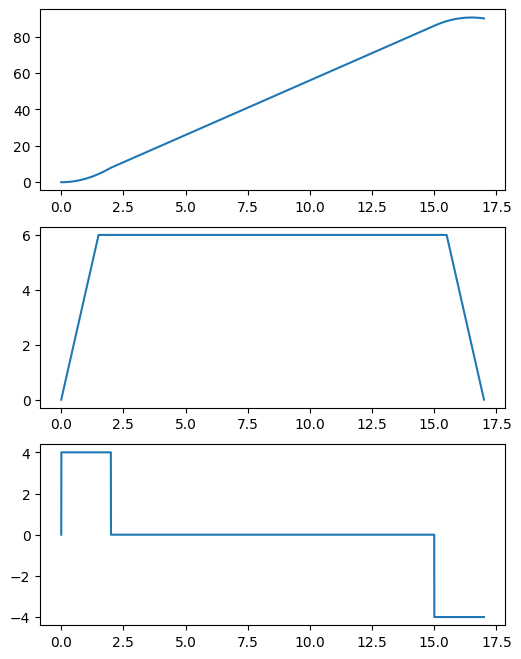

In [ ]:
import numpy as np
from matplotlib.pyplot import *

def plan_trapezoid_trajectory(t_params, q_params):
    q0, qf, dq_max, ddq_max = q_params
    t0, tau, T, tf = t_params
    t = np.linspace(t0, tf, int(3e3))

    dq_max = min(dq_max, (qf - q0)/T)
    print("dq_max", dq_max)
    q = []
    dq = []
    ddq = []

    dq_i = 0
    ddq_i = 0
    for i in t:
        t_i = i
        q_i = q0

        if 0 < t_i <= tau:
            q_i = q0 + 1/2*ddq_max*(t_i-t0)**2
            q02 = q_i

            # if ddq_max * t_i < dq_max:
            #   dq_i = ddq_max * t_i
            # else:
            #   dq_i = dq_max
            dq_i = min(ddq_max * t_i, dq_max)

            dq02 = dq_i
            ddq_i = ddq_max

        elif tau < t_i and t_i <= T:

            q_i = q02 + dq02*(t_i-tau)
            q_03 = q_i
            dq_i = dq_max
            dq03 = dq_i
            ddq_i = 0


        elif t_i > T:
            q_i = q_03 + dq03*(t_i-T) - 1/2*ddq_max*(t_i-T)**2

            dq_i = min(ddq_max*(tf-t_i), dq_max)

            # if  (ddq_max*(tf-t_i)) < dq_max:
            #   dq_i = ddq_max*(tf-t_i)
            # else:
            #   dq_i = dq_max

            ddq_i = -ddq_max

        q.append(q_i)
        dq.append(dq_i)
        ddq.append(ddq_i)

    return t, q, dq, ddq

# _, t1, T, tf = trajectory_time([10, 45, 8, 4])
# _, t1, T, tf = trajectory_time([0,90,8,4])

t_params = [0, 2.0, 15.0, 17.0]
q_params = [0,90,8,4]
t, q, dq, ddq = plan_trapezoid_trajectory(t_params, q_params)

figure(figsize=(6,8))
subplot(311)
plot(t, q)

subplot(312)
plot(t, dq)

subplot(313)
plot(t, ddq)

show()

In [ ]:
def sync_time(t_params_list):

  t0_sync, t_total = 0, 0
  t_dwel = 0

  for t_params in t_params_list:
    t0, tau, T, tf = t_params

    t0_sync = max(t0_sync, t0)
    t_total = max(t_total, tf-t0)
    t_dwel = max(t_dwel, T-tau)

  t0_sync = t0_sync
  tf_sync = t0_sync + t_total
  tau_sync = t0 + (t_total - t_dwel) / 2
  T_sync = tau_sync + t_dwel

  time_params_sync = (t0_sync, tau_sync, T_sync, tf_sync)

  return time_params_sync

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,4]
j2 = [0,60,4,2]

t0=0

#calculate trajectory time for each
j1_t = trajectory_time(j1)
j2_t = trajectory_time(j2)

time_params = (j1_t, j2_t)
print(j1_t, j2_t)
t_params_sync = sync_time(time_params)
t_params_sync

Trapezoidal
Trapezoidal
(0, 2.0, 11.25, 13.25) (0, 2.0, 15.0, 17.0)


(0, 2.0, 15.0, 17.0)

dq_max 6.0


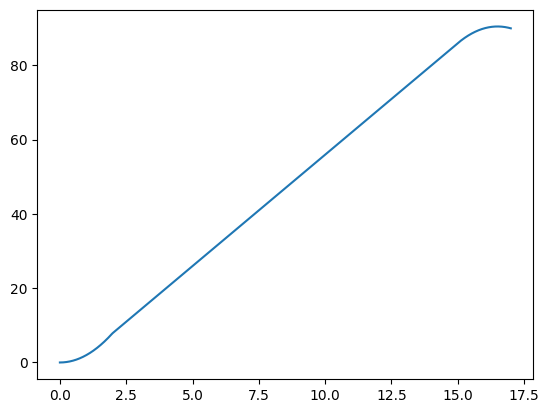

In [ ]:
j1 = [0,90,8,4]
t, q, dq, ddq = plan_trapezoid_trajectory(t_params_sync, j1)
plot(t, q)

dq_max 6.0
dq_max 4


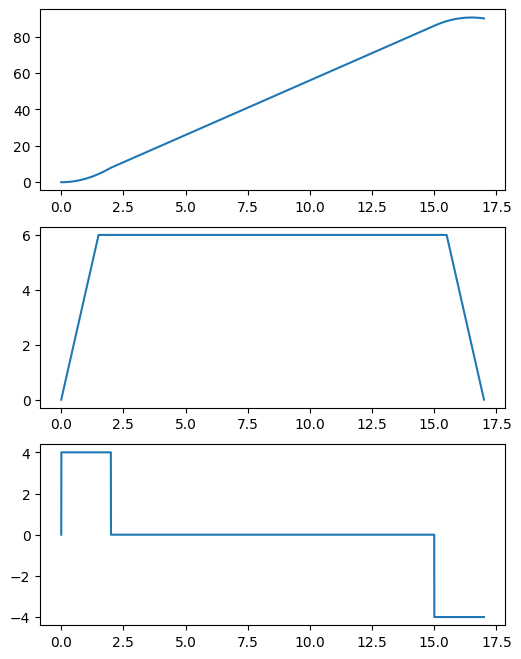

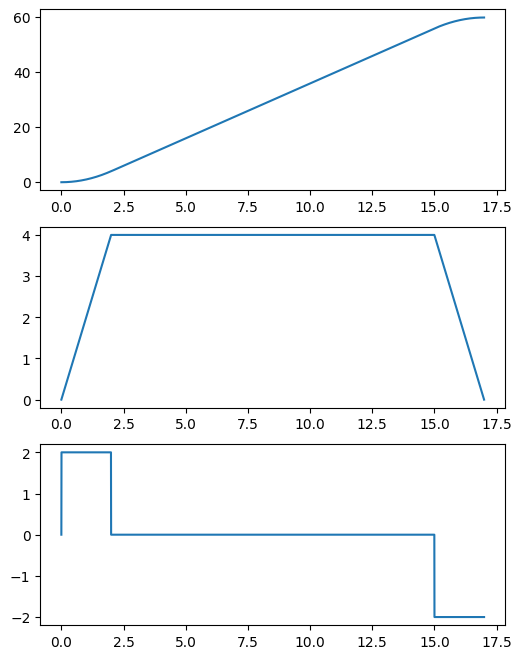

In [ ]:
def plan_sync_trajectory(t_params_sync, q_params_list):

  sync_traj_joints = []

  for q_params in q_params_list:
    sync_traj = plan_trapezoid_trajectory(t_params_sync, q_params)
    sync_traj_joints.append(sync_traj)

  return sync_traj_joints

q_params_list = (j1, j2)
solution = plan_sync_trajectory(t_params_sync, q_params_list)

for i in range(len(solution)):
  t, q, dq, ddq = solution[i]


  figure(figsize=(6,8))
  subplot(311)
  plot(t, q)

  subplot(312)
  plot(t, dq)

  subplot(313)
  plot(t, ddq)

show()